In [1]:
import multiprocessing
import os
import time

import numpy as np
import pandas as pd

from typing import Any, Optional, Tuple

import magic
import gc

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score
from PIL import Image
from tqdm import tqdm

IMAGE_SIZE = 100
PADDING_SIZE = 4

LEARNING_RATE = 1e-4
LR_STEP = 2 ** 5
LR_FACTOR = 0.1
BATCH_SIZE = 64
NUM_CLASSES = 2
NUM_WORKERS = multiprocessing.cpu_count()
NUM_EPOCHS = 2 ** 7

PATH = 'model_densenet121.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print(device)

cuda:0


In [2]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, mode: str) -> None:
        print(f'creating data loader - {mode}')

        self.df = dataframe
        self.mode = mode

        transforms_list = []

        if self.mode == 'train':
            transforms_list = [
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomAffine(degrees=20)
                ])
            ]
            
        transforms_list.extend([
            transforms.Resize((IMAGE_SIZE - PADDING_SIZE, IMAGE_SIZE - PADDING_SIZE)),
            transforms.Pad(PADDING_SIZE, padding_mode='constant'),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
        ])
        self.transforms = transforms.Compose(transforms_list)
        self.targets = dataframe['target'].values

    def __getitem__(self, index: int) -> Any:
        ''' Returns: tuple (sample, target) '''
        filename = self.df['filename'].values[index]
        sample = Image.open(filename)
        assert sample.mode == 'RGB'
        image = self.transforms(sample)

        if self.mode == 'train':
            return image, self.df['target'].values[index]
        else:
            return image, self.df['target'].values[index], filename

    def __len__(self) -> int:
        return self.df.shape[0]

In [3]:
def get_filenames(path):
    filenames = []
    for root, _, files in os.walk(path):
        for _file in files:
            if magic.from_file(os.path.join(root, _file), mime=True).split('/')[0] == 'image':
                filenames.append(os.path.join(root, _file))
    return filenames


def get_data(filenames, train=True):
    images = []
    if train:
        target = []
    for filename in filenames:
        images.append(filename)
        if train:
            target.append(int(filename.split('_')[1]))
    if train:
        return np.array(images), np.array(target)
    else:
        return np.array(images)
        

def split_train_test(x, y, test_size):
    test = []
    for value in np.unique(y):
        mask = y == value
        test_samples = int(np.ceil(mask.sum() * test_size))
        test.extend(np.random.choice(np.where(mask)[0], size=test_samples, replace=False))
    train = list(set(np.arange(0, x.shape[0])) - set(test))
    return x[train], y[train], x[test], y[test]

In [4]:
def load_data(path: str='faces/') -> 'Tuple[DataLoader[np.ndarray], DataLoader[np.ndarray], DataLoader[np.ndarray]]':
    torch.multiprocessing.set_sharing_strategy('file_system')
    cudnn.benchmark = True

    print('loading data...')
    x, y = get_data(get_filenames(path))
    
    x_train, y_train, x_test, y_test = split_train_test(x, y, 0.2)
    train_df = pd.DataFrame(data={'filename': x_train, 'target': y_train})
    test_df = pd.DataFrame(data={'filename': x_test, 'target': y_test})
    whole_df = pd.DataFrame(data={'filename': x, 'target': y})

    train_dataset = ImageDataset(train_df, mode='train')
    test_dataset = ImageDataset(test_df, mode='train')
    whole_dataset = ImageDataset(whole_df, mode='whole')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=NUM_WORKERS)
    
    whole_loader = DataLoader(whole_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    return train_loader, test_loader, whole_loader

In [5]:
def train(data_loader):
    model.train()
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
            
def evaluate(data_loader):
    model.eval() 
    loss = 0.0
    correct_fake = 0
    correct_real = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss += F.cross_entropy(outputs, labels, reduction = 'sum').item()

            pred = outputs.data.max(1, keepdim=True)[1]
            
            mask_real = labels == 1
            mask_fake = labels == 0
            
            correct_fake += pred[mask_fake].eq(labels[mask_fake].data.view_as(pred[mask_fake])).cpu().sum()
            correct_real += pred[mask_real].eq(labels[mask_real].data.view_as(pred[mask_real])).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    total_fake = (data_loader.dataset.targets == 0).sum()
    total_real = (data_loader.dataset.targets == 1).sum()

    print('Average loss: {:.4f}, Accuracy fake: {}/{} ({:.3f}%), Accuracy real: {}/{} ({:.3f}%)'.format(
        loss, correct_fake, total_fake,
        100. * correct_fake / total_fake, correct_real, total_real, 100. * correct_real / total_real))
    return loss, 100. * correct_fake / total_fake, 100. * correct_real / total_real

In [6]:
train_loader, test_loader, whole_loader = load_data('aligned/')
gc.collect()

loading data...
creating data loader - train
creating data loader - train
creating data loader - whole


0

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model = torchvision.models.densenet121(pretrained=True)

model.features.pool0 = Identity()
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP,
                                               gamma=LR_FACTOR)

history_train = []
history_test = []

for epoch in range(NUM_EPOCHS):
    print('-' * 50)
    print('Epoch {}'.format(epoch + 1))
    train(train_loader)
    print('Train', end=' ')
    history_train.append(evaluate(train_loader))
    print('Test', end=' ')
    history_test.append(evaluate(test_loader))
    print()
    lr_scheduler.step(epoch)
    torch.save(model.state_dict(), PATH)

--------------------------------------------------
Epoch 1
Train Average loss: 0.0108, Accuracy fake: 1532/1569 (97.642%), Accuracy real: 16153/16175 (99.864%)
Test Average loss: 0.0161, Accuracy fake: 377/393 (95.929%), Accuracy real: 4040/4044 (99.901%)

--------------------------------------------------
Epoch 2
Train Average loss: 0.0060, Accuracy fake: 1557/1569 (99.235%), Accuracy real: 16138/16175 (99.771%)
Test Average loss: 0.0144, Accuracy fake: 383/393 (97.455%), Accuracy real: 4029/4044 (99.629%)

--------------------------------------------------
Epoch 3
Train Average loss: 0.0042, Accuracy fake: 1566/1569 (99.809%), Accuracy real: 16147/16175 (99.827%)
Test Average loss: 0.0136, Accuracy fake: 389/393 (98.982%), Accuracy real: 4031/4044 (99.679%)

--------------------------------------------------
Epoch 4
Train Average loss: 0.0029, Accuracy fake: 1563/1569 (99.618%), Accuracy real: 16157/16175 (99.889%)
Test Average loss: 0.0079, Accuracy fake: 387/393 (98.473%), Accuracy

Train Average loss: 0.0008, Accuracy fake: 1567/1569 (99.873%), Accuracy real: 16158/16175 (99.895%)
Test Average loss: 0.0081, Accuracy fake: 389/393 (98.982%), Accuracy real: 4040/4044 (99.901%)

--------------------------------------------------
Epoch 34
Train Average loss: 0.0002, Accuracy fake: 1568/1569 (99.936%), Accuracy real: 16159/16175 (99.901%)
Test Average loss: 0.0077, Accuracy fake: 389/393 (98.982%), Accuracy real: 4041/4044 (99.926%)

--------------------------------------------------
Epoch 35
Train Average loss: 0.0003, Accuracy fake: 1569/1569 (100.000%), Accuracy real: 16158/16175 (99.895%)
Test Average loss: 0.0077, Accuracy fake: 390/393 (99.237%), Accuracy real: 4040/4044 (99.901%)

--------------------------------------------------
Epoch 36
Train Average loss: 0.0002, Accuracy fake: 1569/1569 (100.000%), Accuracy real: 16158/16175 (99.895%)
Test Average loss: 0.0075, Accuracy fake: 390/393 (99.237%), Accuracy real: 4041/4044 (99.926%)

--------------------------

Train Average loss: 0.0000, Accuracy fake: 1568/1569 (99.936%), Accuracy real: 16160/16175 (99.907%)
Test Average loss: 0.0085, Accuracy fake: 392/393 (99.746%), Accuracy real: 4040/4044 (99.901%)

--------------------------------------------------
Epoch 66
Train Average loss: 0.0000, Accuracy fake: 1568/1569 (99.936%), Accuracy real: 16160/16175 (99.907%)
Test Average loss: 0.0081, Accuracy fake: 392/393 (99.746%), Accuracy real: 4040/4044 (99.901%)

--------------------------------------------------
Epoch 67
Train Average loss: 0.0000, Accuracy fake: 1568/1569 (99.936%), Accuracy real: 16160/16175 (99.907%)
Test Average loss: 0.0070, Accuracy fake: 391/393 (99.491%), Accuracy real: 4041/4044 (99.926%)

--------------------------------------------------
Epoch 68
Train Average loss: 0.0000, Accuracy fake: 1566/1569 (99.809%), Accuracy real: 16162/16175 (99.920%)
Test Average loss: 0.0083, Accuracy fake: 391/393 (99.491%), Accuracy real: 4041/4044 (99.926%)

----------------------------

Train Average loss: 0.0000, Accuracy fake: 1568/1569 (99.936%), Accuracy real: 16160/16175 (99.907%)
Test Average loss: 0.0082, Accuracy fake: 390/393 (99.237%), Accuracy real: 4040/4044 (99.901%)

--------------------------------------------------
Epoch 98
Train Average loss: 0.0000, Accuracy fake: 1568/1569 (99.936%), Accuracy real: 16160/16175 (99.907%)
Test Average loss: 0.0080, Accuracy fake: 392/393 (99.746%), Accuracy real: 4041/4044 (99.926%)

--------------------------------------------------
Epoch 99
Train Average loss: 0.0000, Accuracy fake: 1566/1569 (99.809%), Accuracy real: 16162/16175 (99.920%)
Test Average loss: 0.0087, Accuracy fake: 392/393 (99.746%), Accuracy real: 4040/4044 (99.901%)

--------------------------------------------------
Epoch 100
Train Average loss: 0.0000, Accuracy fake: 1568/1569 (99.936%), Accuracy real: 16160/16175 (99.907%)
Test Average loss: 0.0081, Accuracy fake: 392/393 (99.746%), Accuracy real: 4041/4044 (99.926%)

---------------------------

In [5]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model = torchvision.models.wide_resnet50_2(pretrained=True)

model.pool0 = Identity()
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)

AttributeError: 'ResNet' object has no attribute 'classifier'

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

history_test = np.array(history_test)
history_train = np.array(history_train)

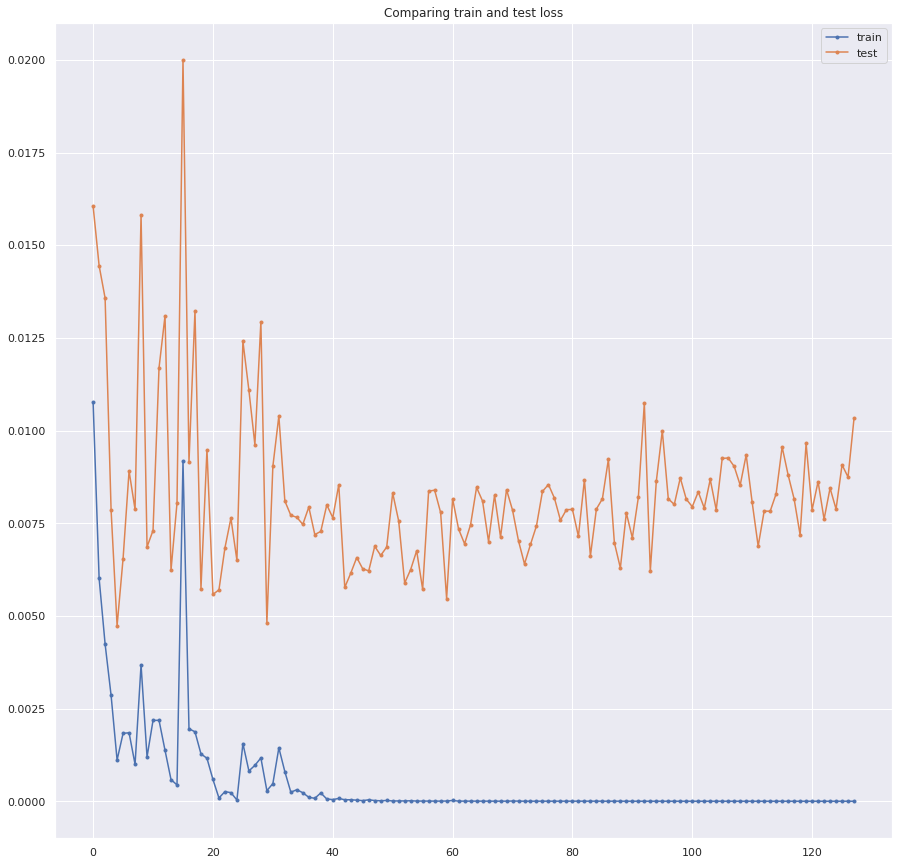

In [9]:
plt.figure(figsize=(15, 15))
plt.title('Comparing train and test loss')
plt.plot(history_train[:, 0], marker='.', label='train')
plt.plot(history_test[:, 0], marker='.', label='test')
plt.legend()
plt.show()

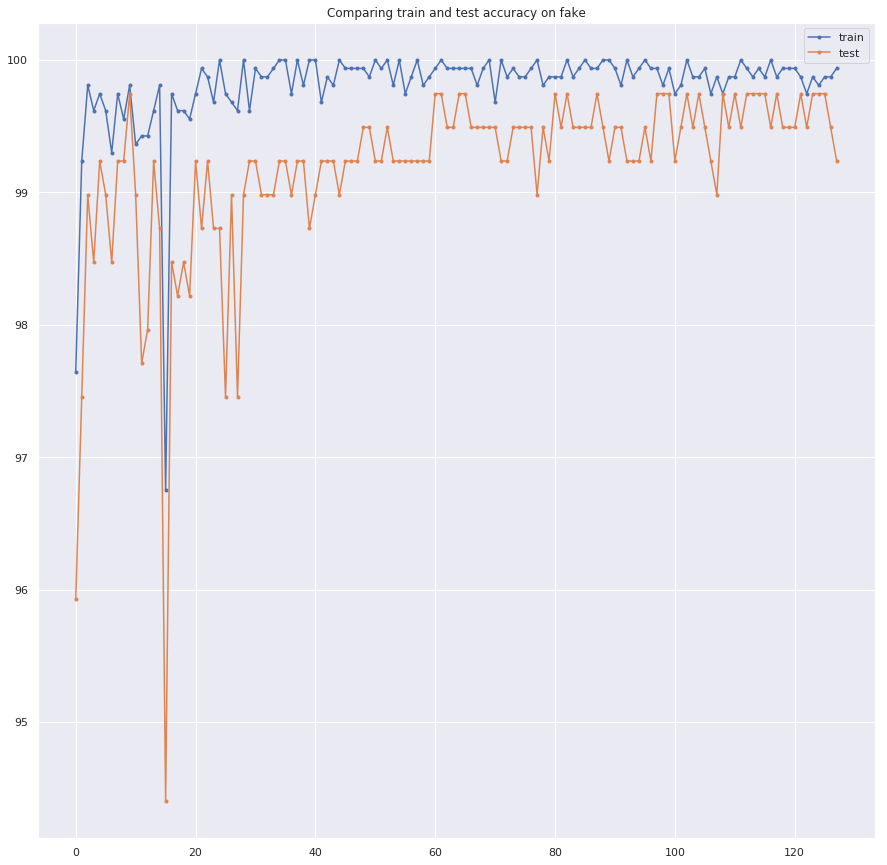

In [10]:
plt.figure(figsize=(15, 15))
plt.title('Comparing train and test accuracy on fake')
plt.plot(history_train[:, 1], marker='.', label='train')
plt.plot(history_test[:, 1], marker='.', label='test')
plt.legend()
plt.show()

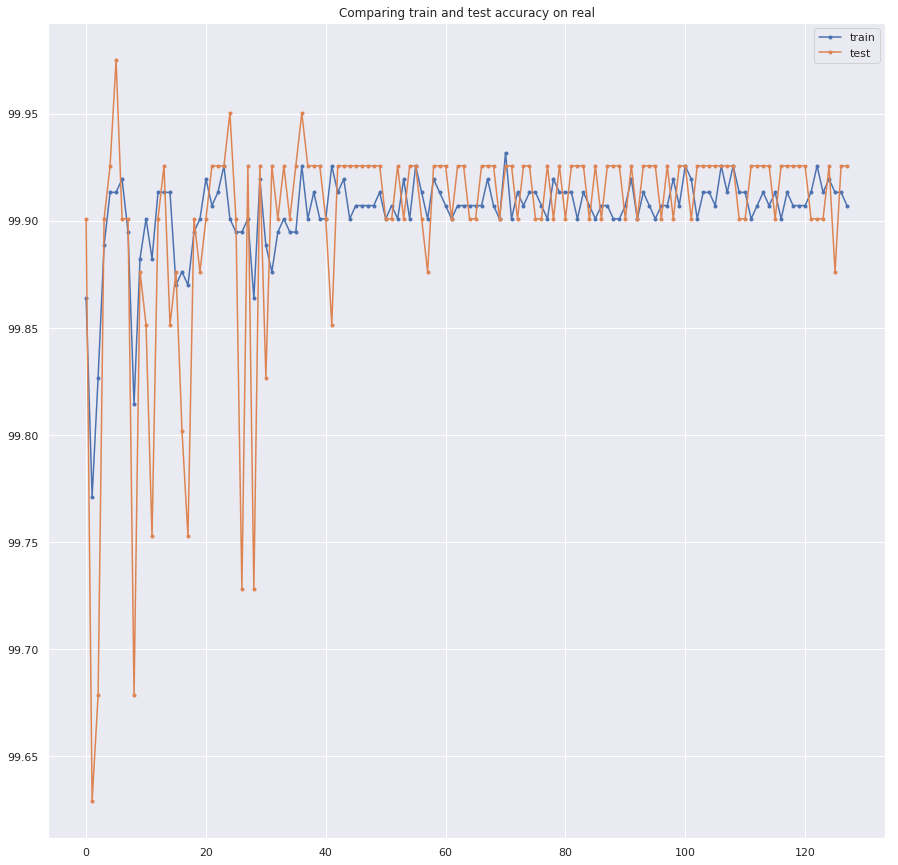

In [11]:
plt.figure(figsize=(15, 15))
plt.title('Comparing train and test accuracy on real')
plt.plot(history_train[:, 2], marker='.', label='train')
plt.plot(history_test[:, 2], marker='.', label='test')
plt.legend()
plt.show()

In [12]:
def prediction(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)

            outputs = model(images)

            pred = outputs.cpu().data.max(1, keepdim=True)[1]

            test_pred = torch.cat((test_pred, pred), dim=0)

    return test_pred

def prediction_(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)

            outputs = model(images)

            pred = outputs.cpu().data.max(1, keepdim=True)[1]

            test_pred = torch.cat((test_pred, pred), dim=0)

    return test_pred

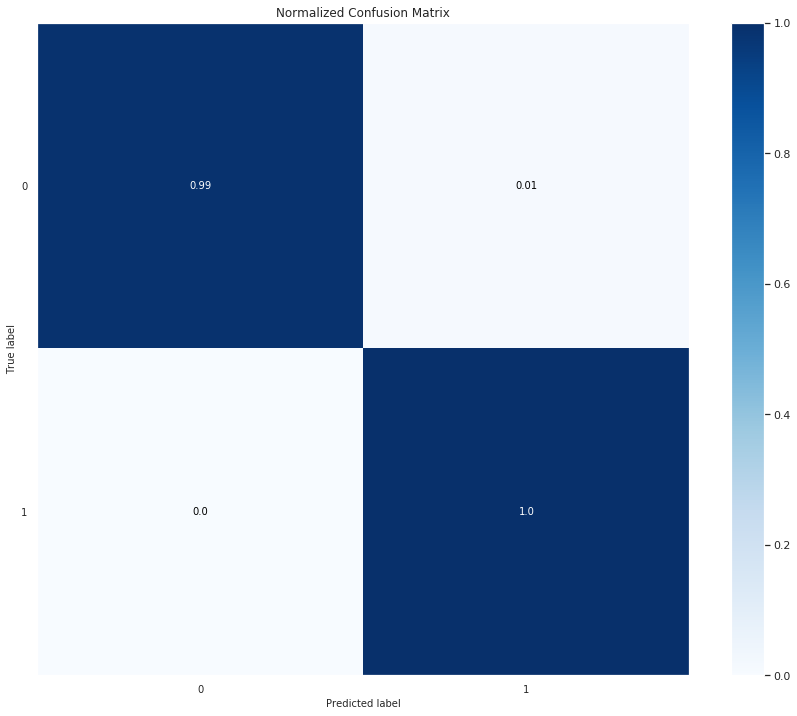

In [13]:
import scikitplot

scikitplot.metrics.plot_confusion_matrix(test_loader.dataset.targets, prediction_(test_loader), normalize=True, figsize=(15, 12))
plt.show()

In [14]:
from sklearn.manifold import TSNE

final = model._modules.get('classifier')
inputs = []

def collect_inputs(m, i, o):
    inputs.append(i)
    
hs = final.register_forward_hook(collect_inputs)

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        model(images)
        
hs.remove()

In [15]:
inputs = np.array(inputs)

new_x = []
for elem in inputs:
    for _ in elem[0]:
        new_x.append(np.array(_.cpu()))
        
new_x = np.array(new_x)

In [16]:
x_transformed = TSNE().fit_transform(new_x)

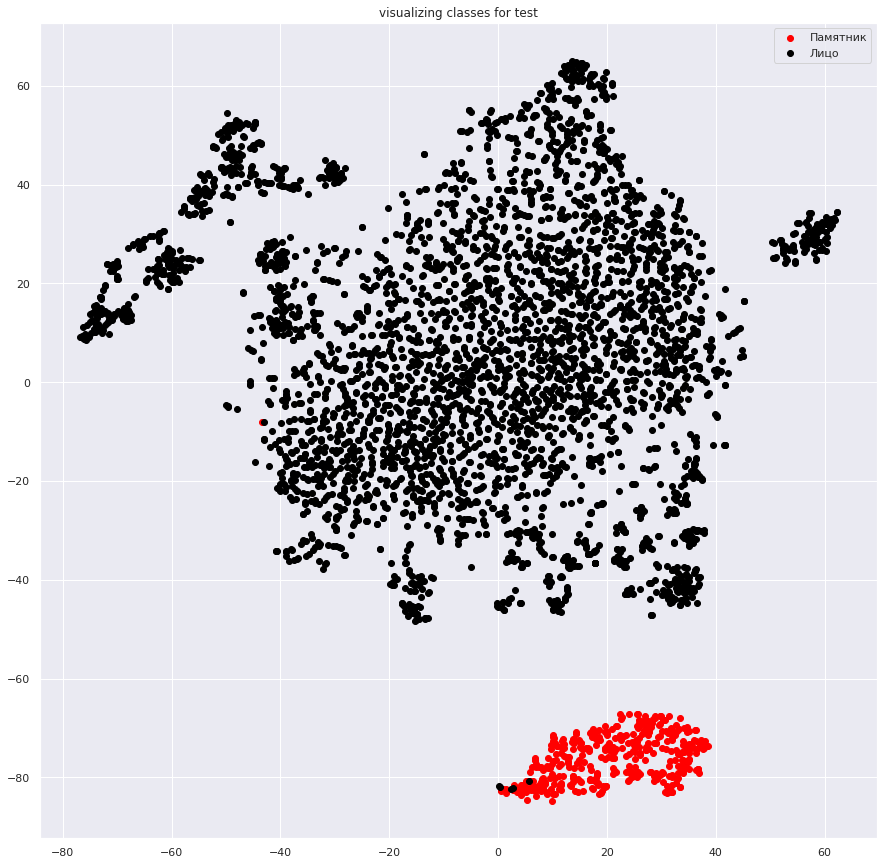

In [17]:
colors = ['red', 'black']
names = ['Памятник', 'Лицо']

plt.figure(figsize=(15, 15))
plt.title('visualizing classes for test')

for i in range(2):
    mask = np.array(test_loader.dataset.targets) == i
    plt.scatter(x_transformed[:, 1][mask], x_transformed[:, 0][mask], label=names[i], color=colors[i])
plt.legend()
plt.show()

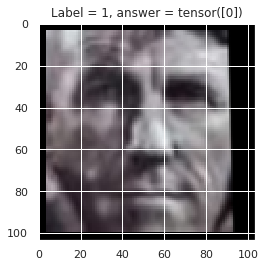

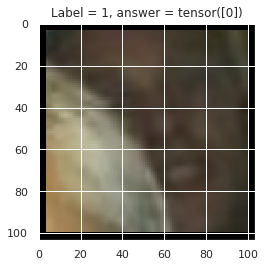

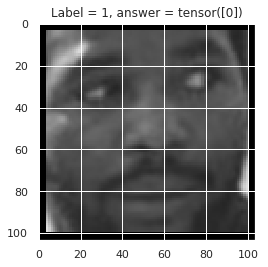

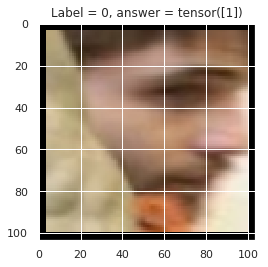

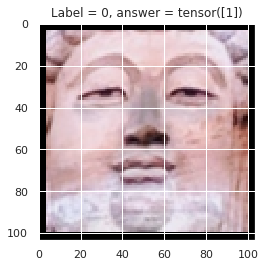

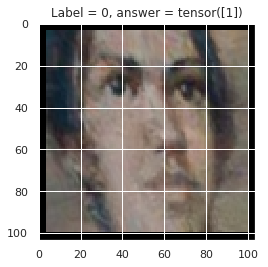

In [18]:
transforms_list = []
transforms_list.extend([
    transforms.Resize((IMAGE_SIZE - PADDING_SIZE, IMAGE_SIZE - PADDING_SIZE)),
    transforms.Pad(PADDING_SIZE, padding_mode='constant')
])
transforms_ = transforms.Compose(transforms_list)

with torch.no_grad():
    for images, labels, filenames in whole_loader:
        images = images.to(device)

        outputs = model(images)

        pred = outputs.cpu().data.max(1, keepdim=True)[1]
        
        for i in range(len(labels)):
            if pred[i] != labels[i]:
                plt.title('Label = {}, answer = {}'.format(labels[i], pred[i]))
                plt.imshow(transforms_(Image.open(filenames[i])))
                plt.show()

In [19]:
path = 'model_huge.pth'

torch.save(model.state_dict(), path)

In [20]:
_, _, whole = load_data('alignedQuantigo/')
gc.collect()

loading data...
creating data loader - train
creating data loader - train
creating data loader - whole


23035

In [21]:
def evaluate_(data_loader):
    model.eval() 
    loss = 0.0
    correct_fake =     correct_real = 0
    
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss += F.cross_entropy(outputs, labels, reduction = 'sum').item()

            pred = outputs.data.max(1, keepdim=True)[1]
            
            mask_real = labels == 1
            mask_fake = labels == 0
            
            correct_fake += pred[mask_fake].eq(labels[mask_fake].data.view_as(pred[mask_fake])).cpu().sum()
            correct_real += pred[mask_real].eq(labels[mask_real].data.view_as(pred[mask_real])).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    total_fake = (data_loader.dataset.targets == 0).sum()
    total_real = (data_loader.dataset.targets == 1).sum()

    print('Average loss: {:.4f}, Accuracy fake: {}/{} ({:.3f}%), Accuracy real: {}/{} ({:.3f}%)'.format(
        loss, correct_fake, total_fake,
        100. * correct_fake / total_fake, correct_real, total_real, 100. * correct_real / total_real))
    return loss, 100. * correct_fake / total_fake, 100. * correct_real / total_real



evaluate_(whole)

Average loss: 0.4007, Accuracy fake: 247/339 (72.861%), Accuracy real: 10570/11284 (93.672%)


(0.4006914758163281, tensor(72.8614), tensor(93.6725))